In [1]:
## Functions for linear interpolation ##

# Lowest level function - interpolates between two points
function interp_pts(x1, y1, x2, y2, x0)
  if(x2-x1 == 0)
    return (y1+y2)/2
  end
  slope = (y2-y1)/(x2-x1)
  return y1 + slope*(x0-x1)
end

# Interpolates between two vectors
# Assume that the time vectors are sorted.
function interp1(new_time, old_data, old_time)
  new_data = zeros(size(new_time,1),size(old_data,2))
  old_ind = 1
  new_ind = 1

  while(new_ind <= size(new_data,1))
    # Get started 
    i = findfirst( old_time.> new_time[new_ind])
    if(i == 0)
      println("Warning: new_time not contained in old time")
      if(old_ind == 1)
        return []
      else
        new_data[new_ind,:] = new_data[new_ind-1,:]
      end 
    elseif(i==1)
      println("Warning: No history")
      new_data[new_ind,:] = old_data[i,:]
    else
      new_data[new_ind,:] = interp_pts(old_time[i-1], old_data[i-1,:], old_time[i], old_data[i,:], new_time[new_ind])
    end
    old_ind +=1 
    new_ind +=1
  end
  return new_data
end

## Fucntions for loading data ##
function load_features()
    data = readcsv("features.csv")
    t = data[:,1]
    t -= t[1]
    return t, data[:,2]
end

function load_data()
    data = readcsv("_slash_tf.csv")
    data2 = readcsv("_slash_tf2.csv")
    return (data,data2)
end
data, data2 = load_data()
    # strip out headers
    headers = data[1,:] # Note there's an extra "-" header that shifts things
    headers2 = data2[1,:] # Note there's an extra "-" header that shifts things
    data = data[2:end,:]
    data2 = data2[2:end,:]
    # strip out useful information:
    t = data[:,1]*(1.0e-9);       # rosbag timestamps - units S
    t2 = data2[:,1]*(1.0e-9);
    t -= t[1]
    t2 -= t2[1]    
    frame_id = data[:,9] # This is actually "child_frame_id", but they're still unique
    frame_id2 = data2[:,9]
    # Warning: some of these values have empty strings, so a typecast may not work.
    tra = data[:,12:14] # Translation: XYZ
tra2 = data2[:,12:14]
    rot = data[:,15:18] # Rotation: XYZW
rot2 = data2[:,15:18]

    # sort the data by frame:
    vicon_inds = find(frame_id.=="vicon/quad_1/quad_1")
vicon_inds2 = find(frame_id2.=="vicon/quad_1/quad_1")
    tango_inds = find(frame_id.=="device")
tango_inds2 = find(frame_id2.=="device")
    sos_inds    = find(frame_id.=="start_of_service")
sos_inds2    = find(frame_id2.=="start_of_service");




In [2]:
size(t)

(60696,)

In [3]:
size(t[tango_inds])

(23725,)

In [4]:
size(tra[tango_inds,:])

(23725,3)

In [5]:
size(t2)

(235715,)

In [6]:
size(t2[tango_inds2])

(90563,)

In [7]:
size(tra2[tango_inds2,:])

(90563,3)

In [8]:
        # Interpolate so on the same scale.
    v_interp = interp1(t[tango_inds], tra[vicon_inds,:], t[vicon_inds]);
    v_interp2 = interp1(t2[tango_inds2], tra2[vicon_inds2,:], t2[vicon_inds2]);

In [9]:
size(v_interp)

(23725,3)

In [10]:
size(v_interp2)

(90563,3)

In [11]:
   # Code from Brian - thanks!
    # First 1000 measurements or so are of the same position
# compute transform over all data
    # Compute transform using least squares
    # Write up here: https://igl.ethz.ch/projects/ARAP/svd_rot.pdf
    # A = p, B = q in their notation.
    A = tra[tango_inds,:]# rot[tango_inds[start_inds]]]
    B = v_interp;
#B = tra[tango_inds[start_inds],:]# rot[vicon_inds[start_inds]]]

    centroid_A = [mean(A[:,1]); mean(A[:,2]); mean(A[:,3])]
    centroid_B = [mean(B[:,1]); mean(B[:,2]); mean(B[:,3])]
    N = size(A,1)

    H = (A - repmat(centroid_A',N,1))' * (B - repmat(centroid_B', N, 1))
    H = convert(Array{Float64,2},H)

    U, S, V = svd(float(H))
    R = V*U'
    if det(R) < 0
        V[:,3] *= -1
        R = V*U'
    end

    offset = -R*centroid_A + centroid_B

    # transformed coordinates:
    tra_t = broadcast(+,(R*(tra[tango_inds,:]')),offset)'

23725×3 Array{Float64,2}:
 1.07381    0.0241519  0.200858
 1.07381    0.0241506  0.200858
 1.07381    0.0241487  0.200858
 1.07381    0.0241481  0.200858
 1.07381    0.0241473  0.200858
 1.07381    0.0241466  0.200858
 1.07381    0.0241459  0.200858
 1.07381    0.0241452  0.200858
 1.07381    0.0241444  0.200858
 1.07381    0.0241437  0.200859
 1.07381    0.024143   0.200859
 1.07381    0.0241423  0.200859
 1.07381    0.0241404  0.200859
 ⋮                             
 0.514046  -0.828102   1.34893 
 0.516118  -0.829281   1.34925 
 0.518188  -0.830469   1.34954 
 0.520284  -0.831681   1.34981 
 0.52239   -0.832914   1.35007 
 0.524491  -0.834161   1.35031 
 0.526601  -0.835434   1.35053 
 0.528732  -0.836742   1.35074 
 0.530868  -0.83806    1.35096 
 0.533025  -0.839417   1.35118 
 0.535175  -0.840797   1.35138 
 0.537346  -0.842218   1.35158 

In [12]:
       # Code from Brian - thanks!
    # First 1000 measurements or so are of the same position
# transform on all of data
    # Compute transform using least squares
    # Write up here: https://igl.ethz.ch/projects/ARAP/svd_rot.pdf
    # A = p, B = q in their notation.
    tsfm_inds = 22500:90563
tra_tango_section = tra2[tango_inds2,:] 
    A2 = tra_tango_section[tsfm_inds,:]# rot[tango_inds[start_inds]]]
B2 = v_interp2[tsfm_inds,:];
#B = tra[tango_inds[start_inds],:]# rot[vicon_inds[start_inds]]]

    centroid_A2 = [mean(A2[:,1]); mean(A2[:,2]); mean(A2[:,3])]
    centroid_B2 = [mean(B2[:,1]); mean(B2[:,2]); mean(B2[:,3])]
    N2 = size(A2,1)

    H2 = (A2 - repmat(centroid_A2',N2,1))' * (B2 - repmat(centroid_B2', N2, 1))
    H2 = convert(Array{Float64,2},H2)

    U2, S2, V2 = svd(float(H2))
    R2 = V2*U2'
    if det(R2) < 0
        V2[:,3] *= -1
        R2 = V2*U2'
    end

    offset2 = -R2*centroid_A2 + centroid_B2

    tra_t2 = broadcast(+,(R2*(tra2[tango_inds2,:]')),offset2)'

90563×3 Array{Float64,2}:
  1.71372  -1.06138  2.76   
  1.71218  -1.05838  2.75974
  1.71067  -1.05535  2.7595 
  1.70915  -1.05227  2.75928
  1.70764  -1.04918  2.75907
  1.70614  -1.04603  2.75887
  1.70465  -1.04287  2.75869
  1.70178  -1.03633  2.75831
  1.69897  -1.02965  2.75795
  1.69758  -1.02623  2.75778
  1.69622  -1.02278  2.7576 
  1.69487  -1.01927  2.75742
  1.69353  -1.01574  2.75723
  ⋮                         
 -1.34749  -1.74501  1.21407
 -1.35313  -1.74357  1.21451
 -1.36435  -1.74041  1.21541
 -1.37955  -1.73545  1.21666
 -1.3846   -1.73365  1.21709
 -1.38968  -1.73175  1.21753
 -1.39474  -1.7298   1.21797
 -1.39982  -1.72777  1.21842
 -1.40486  -1.72567  1.21887
 -1.40989  -1.72351  1.21932
 -1.41539  -1.72106  1.21981
 -1.42102  -1.71847  1.22031

In [13]:
size(t)

(60696,)

In [14]:
#size(t[tango_inds])

In [15]:
size(t2)

(235715,)

In [16]:
t = t[tango_inds]
t2 = t2[tango_inds2];

In [17]:

tra_tango = tra_t
tra_tango2 = tra_t2
tra_vicon = v_interp;
tra_vicon2 = v_interp2;


In [18]:
using PyPlot

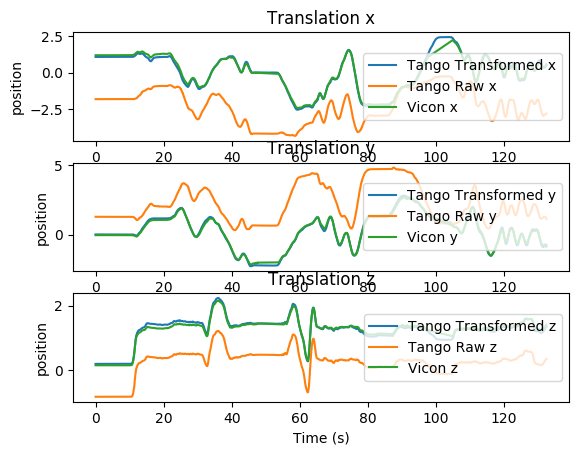

In [19]:
# Show XYZ data along
figure(1); clf()
ax = ["x","y","z"]
for k=1:3
    subplot(3,1,k)
    title("Translation $(ax[k])")
        tra_raw = tra[tango_inds,k]
        plot(t, tra_tango[:,k])
        plot(t, tra_raw)
        plot(t, tra_vicon[:,k])
        legend(["Tango Transformed $(ax[k])", "Tango Raw $(ax[k])", "Vicon $(ax[k])"],loc="right")
    ylabel("position")
    xlabel("Time (s)")
end

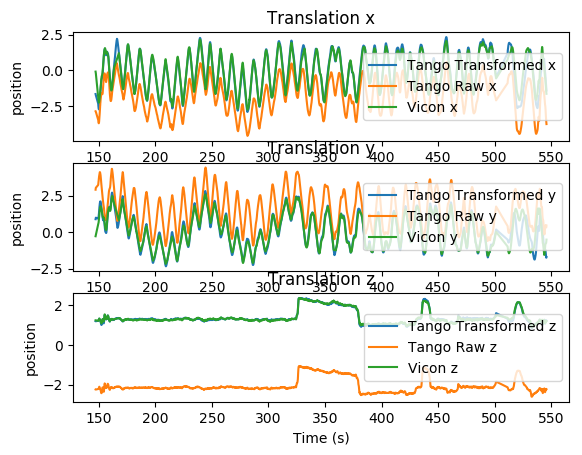

In [20]:
figure(2); clf()
ax = ["x","y","z"]
for k=1:3
    subplot(3,1,k)
    title("Translation $(ax[k])")
        tra_raw2 = tra2[tango_inds2,k]
        plot(t2[22500:end], tra_tango2[22500:end,k])
        plot(t2[22500:end], tra_raw2[22500:end])
        plot(t2[22500:end], tra_vicon2[22500:end,k])
        legend(["Tango Transformed $(ax[k])", "Tango Raw $(ax[k])", "Vicon $(ax[k])"],loc="right")
    ylabel("position")
    xlabel("Time (s)")
end

In [21]:
function estimate_error(t, tra_tango, tra_vicon)
    # Estimate error rate using an exponential filter:
    error = tra_vicon - tra_tango;

    error_rate = zeros(size(error))
    t_elapsed = 0;
    rate = 0.999
    
    dx_last = 0;
    for (iter,) in enumerate(t)
       if(iter==1)
         error_rate[iter] =  0
         v_last = 0
       else
         dx_inst = (error[iter,:]-error[iter-1,:])
         dx_last = rate*dx_last + (1-rate)*dx_inst

         dt = t[iter]-t[iter-1] 
         t_elapsed = rate*t_elapsed + (1-rate)*dt # average number of measurements
         error_rate[iter,:] = dx_last/t_elapsed #rate*error_rate[iter-1] + (1-rate)*v_inst
       end
    end
    return error, error_rate
end

estimate_error (generic function with 1 method)

In [22]:
# Estimate error rates
error2, error_rate2 = estimate_error(t2[22500:end], tra_tango2[22500:end,:], tra_vicon2[22500:end,:]);

In [23]:
size(error_rate2)

(68064,3)

In [26]:
data_to_write = hcat(t2[22600:end], tra_tango2[22600:end,:], tra_vicon2[22600:end,:], error_rate2[101:end,:])
writecsv("trasnformed_data_slash_2.csv", data_to_write)

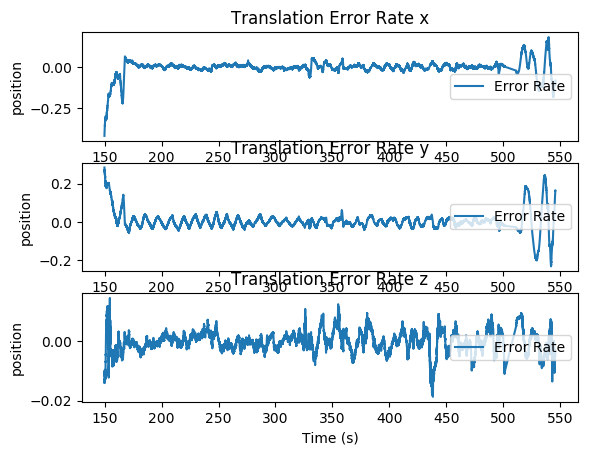

In [25]:
figure(3); clf()
ax = ["x","y","z"]
for k=1:3
    subplot(3,1,k)
    title("Translation Error Rate $(ax[k])")
    plot(t2[22600:end], error_rate2[101:end,k])
    legend(["Error Rate"],loc="right")
    ylabel("position")
    xlabel("Time (s)")
end